In [242]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import scikitplot as skplt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
import geopandas as gpd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar


In [229]:
# set working directory
os.chdir("/Users/jasonchan/Documents/DataProjects")

# read in stop data
stops = pd.read_csv("WI-clean.csv", parse_dates = ['stop_date'], low_memory = False)
# read in county segregation data
seg = pd.read_csv("WI_segregation.csv")

# drop rows where driver race is not specified
stops = stops[stops.driver_race.notnull()]

In [230]:
# change contraband_found, is_arrested to bool, then int
stops[['contraband_found','is_arrested']] = (stops[['contraband_found','is_arrested']] == 'TRUE').astype(int)

# change stop_time to datetime
stops['stop_time'] = pd.to_datetime(stops['stop_time'], format='%H:%M')

# change drugs_related_stop to int
stops['drugs_related_stop'] = stops['drugs_related_stop'].astype(int)

# change location, driver_race to str
stops['location_raw'] = stops['location_raw'].apply(str)

In [231]:
minorities = ['Black', 'Hispanic']

# stops where search was conducted and contrabound was found
successful_stops = stops.loc[stops['contraband_found'] == 1]

# minority stops
minority_stops = stops.loc[stops['driver_race'].isin(minorities)]

# white stops
white_stops = stops.loc[stops['driver_race'] == 'White']

# hit rate among minorities
minority_searches = minority_stops.loc[minority_stops['search_conducted'] == 1] # minority stops where search was conducted
successful_minority_stops = successful_stops.loc[successful_stops['driver_race'].isin(minorities)] # minority stops where contraband was found
minority_hit = successful_minority_stops.shape[0] / minority_searches.shape[0] # minority hit rate 

# hit rate among whites
white_searches = stops.loc[(stops['driver_race'] == 'White') & stops['search_conducted'] == 1]
successful_white_stops = successful_stops.loc[successful_stops['driver_race'] == 'White']
white_hit = successful_white_stops.shape[0] / white_searches.shape[0] # white hit rate

In [232]:
# What are search percentages, arrest percentages, contraband percentages by race, percentages that are drug related?

# drug related stops
drug_related_stops = 
# group stops dataframe by driver_race
race_outcomes = stops.groupby(['driver_race']).apply(lambda x: (x[['is_arrested', 'contraband_found', 'search_conducted', 'drugs_related_stop']].sum()/len(x)) * 100).reset_index()
race_outcomes.columns = ['driver race', 'arrest rate', 'contraband rate', 'search rate', 'percent drugs related']
race_outcomes



,driver race,arrest rate,contraband rate,search rate,percent drugs related
0,Asian,0.972986,0.492651,1.046884,0.365383
1,Black,3.757043,2.318674,4.849772,1.620191
2,Hispanic,3.152585,1.246704,3.049410,0.796744
3,Other,4.147833,1.825756,3.616060,1.356022
4,White,1.252425,0.654874,1.244402,0.492999


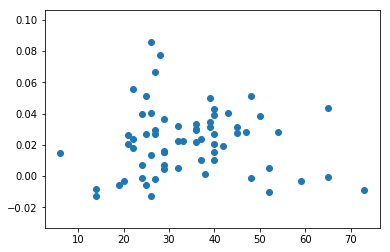

In [237]:
# remove counties with less than 1000 observations
county_stops_group = stops.groupby('location_raw').filter(lambda x: len(x) >= 1000)
# obtain observation counts for each county
county_stops = county_stops_group.groupby('location_raw').size().reset_index(name='counts')
# change column name of 'location_raw' to 'county'
county_stops.columns = ['county', 'count']

# Do more segregated counties have larger disparities in search rates between blacks and whites?

# calculate difference in search rates between whites and minorities per county
def stop_rate(county):
    minority_rate = minority_searches.loc[minority_searches['location_raw'] == county].shape[0] / minority_stops.loc[minority_stops['location_raw'] == county].shape[0]
    white_rate = white_searches.loc[white_searches['location_raw'] == county].shape[0] / white_stops.loc[white_stops['location_raw'] == county].shape[0]
    return(minority_rate - white_rate)

# stop rates for every county
stop_rates = county_stops['county'].apply(lambda x: stop_rate(x))
# append to county_stops column
county_stops['stop_rates'] = stop_rates

# merge county and segregation dataframe
county_seg = pd.merge(county_stops, seg, how = 'inner', on = 'county')
# remove rows with NaN
county_seg = county_seg.dropna()

# plot segregation index and stop_rates
plt.scatter(x = county_seg['segregation'], y = county_seg['stop_rates'])

# do more segregated areas search minorities more? 

In [257]:
# create copy of stops dataframe
stops_copy = stops.copy(deep = True)

# encode driver gender
stops_copy['gender'] = stops_copy['driver_gender'].map(dict(F = 0, M = 1))
    
# Feature extraction
    
# day of week
stops_copy['day_of_week'] = stops_copy['stop_date'].map(lambda x: x.weekday())

# hour
stops_copy['hour'] = stops_copy['stop_time'].dt.hour

# weekend identifier
stops_copy['weekend'] = stops_copy['day_of_week'].isin([5,6]) * 1 

# holiday or not
cal = calendar()
holidays = cal.holidays(start= stops_copy['stop_date'].min(), end = stops_copy['stop_date'].max())
stops_copy['holiday'] = stops_copy['stop_date'].isin(holidays) * 1

In [267]:
# select relevant columns
stops_copy = stops_copy[['gender', 'driver_race','hour', 'weekend', 'holiday', 'search_conducted']]

# dummy encode driver race
stops_enc = pd.get_dummies(data = stops_copy, columns = ['driver_race'])

# remove any rows with missing values
stops_enc = stops_enc.dropna()
stops_enc.head()

,gender,hour,weekend,holiday,search_conducted,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White
0,0.0,12.0,0,1,0.0,0,0,0,0,1
1,1.0,16.0,1,0,0.0,0,0,0,0,1
2,0.0,9.0,0,0,0.0,0,0,0,0,1
3,1.0,9.0,0,0,0.0,0,0,0,0,1
4,1.0,23.0,0,0,0.0,0,1,0,0,0


Model Construction


In [268]:
# set random seed
np.random.seed(0)

# split features and target variable
y = stops_enc['search_conducted']
x = stops_enc.drop(['search_conducted'], axis = 1)

# split into train and test set
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.25, random_state = 0)

# set parameters
parameters = {'bootstrap': True,
             'min_samples_leaf': 3,
             'n_estimators': 500,
             'min_samples_split': 10,
             'class_weight': {0:1,1:5}
             }

# define model
rf_model = RandomForestClassifier(**parameters)

# fit model
rf_fit = rf_model.fit(train_x, train_y)

In [ ]:
'class_weight' = class_weight={0:1,1:2}

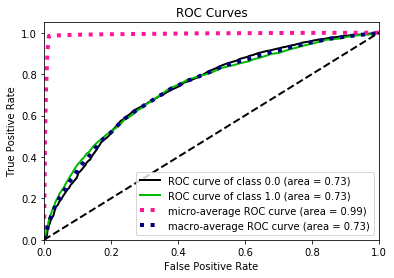

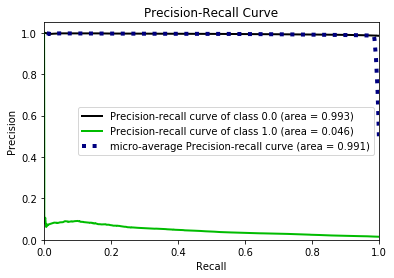

array([[189878,     23],
       [  2842,      2]])

In [269]:
# randomforest predictions as probabilities
rf_probs = rf_fit.predict_proba(test_x)

# class predictions
rf_preds = rf_fit.predict(test_x)

# ROCR cuve, AUC
s
kplt.metrics.plot_roc(test_y, rf_probs)
plt.show()

# Precision-Recall Curve

skplt.metrics.plot_precision_recall(test_y, rf_probs)
plt.show()

# confusion matrix
confusion_matrix(test_y, rf_preds)

In [270]:
# feature importance
pd.DataFrame(rf_model.feature_importances_,
             index = train_x.columns,
             columns = ['importance']).sort_values('importance', ascending = False)

,importance
hour,0.620921
driver_race_Black,0.124370
driver_race_White,0.079429
gender,0.074395
weekend,0.038438
driver_race_Asian,0.024906
driver_race_Hispanic,0.017491
driver_race_Other,0.010681
holiday,0.009368


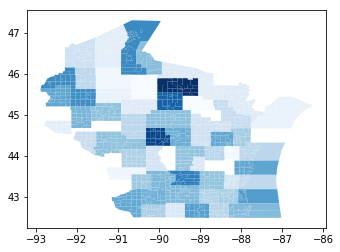

In [224]:
# Geopandas visualization of county-level segregation 

# read in shape file
map_df = gpd.read_file('tl_2015_55_cousub.shp')
# read in counties file
counties_num = pd.read_csv('WI_counties.csv')

map_df['county_id'] = map_df['COUNTYFP'].astype(int)

# merge counties_seg and WI_counties, obtaining numerical identifiers for each county
wi_counties = pd.merge(counties_num, county_seg, how = 'inner', on = 'county')

# change county_id type to int
wi_counties['county_id'] = wi_counties['county_id'].astype(int)

# drop unnecessary columns
map_df = map_df[['county_id', 'geometry']]

# merge wi_counties with shape dataframe
merged = pd.merge(map_df, wi_counties, on = 'county_id', how = 'left')

# rename segregation column
merged.rename(columns={'segregation':'seg_index'}, inplace=True)

# remove all rows with NaNs
merged = merged.dropna()

# create chloropeth
merged.plot(column = 'stop_rates', cmap = 'Blues', linewidth = 0.8)
